In [2]:
%matplotlib inline

import numpy
import numpy.linalg
import pandas
import scipy.cluster.hierarchy
import sklearn
import sklearn.cluster
import sklearn.linear_model
import re
import matplotlib.pyplot

In [7]:
def ReduceDimensions(data,keep_variance=0.8,tolerance=1.0E-12,max_iter=1024):
    """Reduces dimensions of data"""
    residuals=data-data.mean(axis=1,keepdims=True)
    noise=(1.0-keep_variance)*residuals.var()
    convergence=1.0-tolerance
    result=None
    n=0
    while n<max_iter and residuals.var()>noise:
        component=residuals.var(axis=1,keepdims=True)
        if result is not None:
            component-=(result*(component.T.dot(result))).sum(axis=1,keepdims=True)
        component/=numpy.linalg.norm(component)
        corr=0.0
        n=0
        while n<max_iter and corr<convergence:
            projection=residuals.dot(component.T.dot(residuals).T)
            projection/=numpy.linalg.norm(projection)
            corr=projection.T.dot(component)
            component=projection
            n+=1
        if n<max_iter:
            if result is None:
                result=component
            else:
                result=numpy.hstack([result,component])
            residuals-=numpy.outer(component,component.T.dot(residuals))
    return result

In [8]:
'''Rename Patients function takes a name as input, assumes there is a global variable split_name, splits the name using that variable, and then constructs a new string using the format 'TCGA-component0-component1'.'''

split_name=re.compile('[.-]')

def rename_patients(name):
    components=split_name.split(name)
    return '-'.join(('TCGA',components[0],components[1]))

class BreastCancerAnalysis(object):
    '''Init function reads - 77_cancer_proteomes_CPTAC_itraq file into a pandas DataFrame (self.protein_activity).
    Sets the index of self.protein_activity DataFrame using the specified columns.
    Fills missing values in the DataFrame with the median of the existing values.
    Renames columns of the DataFrame using the rename_patients function.
    Reads another file clinical_data_breast_cancer into a pandas DataFrame (self.clinical_data) and sets the index.'''
    def __init__(self):
        self.protein_activity=pandas.read_csv("data/77_cancer_proteomes_CPTAC_itraq.csv")
        self.protein_activity.set_index(['RefSeq_accession_number','gene_symbol','gene_name'],inplace=True)
        self.protein_activity.fillna(self.protein_activity.median(),inplace=True)
        self.protein_activity.rename(columns=rename_patients,inplace=True)
        self.clinical_data=pandas.read_csv("data/clinical_data_breast_cancer.csv").set_index('Complete TCGA ID')
        self.principal_components=None
        self.protein_clusters=None
        self.patient_protein_activity=None
        self.clinical_prediction_models=None

    def fit_principal_components(self):
        """
        1. Method Purpose:
            - fit_principal_components is intended to reduce the dimensionality of the data stored in self.protein_activity using the ReduceDimensions function.

        2. Function ReduceDimensions:

            - This function takes the data (data), and parameters for keeping variance (keep_variance), tolerance (tolerance), and maximum iterations (max_iter).
            - It starts by computing residuals and noise.
            - It iteratively calculates the components and projections to reduce dimensionality until convergence or reaching the maximum number of iterations.
            - The result is a matrix of reduced dimensions.

        3. Method fit_principal_components Steps:
            - self.protein_activity.values: Accesses the underlying NumPy array of the DataFrame self.protein_activity.
            - ReduceDimensions(self.protein_activity.values): Applies the ReduceDimensions function to the data.
            - pandas.DataFrame(...): Constructs a new DataFrame from the result of the dimensionality reduction.
            - index=self.protein_activity.index: Sets the index of the new DataFrame to be the same as the index of the original self.protein_activity.
            - return self.principal_components: Returns the DataFrame with reduced dimensions."""
        self.principal_components=pandas.DataFrame(ReduceDimensions(self.protein_activity.values),
                                                   index=self.protein_activity.index)
        return self.principal_components

    def dendrogram(self):
        """Performs hierarchical clustering on the principal components data (self.principal_components) and then plots a dendrogram using the ward linkage method. The purpose of this method seems to be to help visualize the structure of the data and decide on the number of clusters to use in further analysis.

        The output of this method is a dendrogram plot, which is a tree diagram used to illustrate the arrangement of the clusters produced by hierarchical clustering. The structure of the dendrogram can provide insights into the relationships between different data points. We found out that it required 8 clusters.
        """
        result=matplotlib.pyplot.gca()
        scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.ward(self.principal_components),ax=result)
        return result

    def cluster_proteins(self,n=2):
        """ Responsible for finding clusters of proteins based on their activity. It uses hierarchical clustering with the AgglomerativeClustering algorithm to group proteins into clusters."""
        clusters=sklearn.cluster.AgglomerativeClustering(n_clusters=n,
                                                         memory='/tmp')
        self.protein_clusters=pandas.DataFrame(clusters.fit_predict(self.principal_components),
                                               index=self.principal_components.index,
                                               columns=['cluster'])
        return self.protein_clusters


    def patient_cluster_activity(self):
        """Calculates the activity of each protein cluster for each patient"""
        mean_subtracted_protein_activity=self.protein_activity.sub(self.protein_activity.values.mean(axis=1),
                                                                   axis='index')
        patient_components=mean_subtracted_protein_activity.T.dot(self.principal_components)
        kernel=self.principal_components.merge(self.protein_clusters,
                                               left_index=True,
                                               right_index=True).groupby('cluster').mean().T
        self.patient_protein_activity=patient_components.dot(kernel)
        return self.patient_protein_activity

    def train_clinical_models(self):
        """Fits a model to predict each clinical feature from the protein activity"""
        self.clinical_prediction_models={'Gender':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'Age at Initial Pathologic Diagnosis':sklearn.linear_model.LassoLars(copy_X=True),
                                         'ER Status':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'PR Status':sklearn.linear_model.LogisticRegression(solver='lbfgs'),
                                         'HER2 Final Status':sklearn.linear_model.LogisticRegression(solver='lbfgs'),
                                         'Tumor':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'Node':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'Metastasis-Coded':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'AJCC Stage':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'Vital Status':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'OS Time':sklearn.linear_model.LassoLars(copy_X=True),
                                         'PAM50 mRNA':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'SigClust Unsupervised mRNA':sklearn.linear_model.LassoLars(copy_X=True),
                                         'miRNA Clusters':sklearn.linear_model.LassoLars(copy_X=True),
                                         'methylation Clusters':sklearn.linear_model.LassoLars(copy_X=True),
                                         'RPPA Clusters':sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='multinomial'),
                                         'Integrated Clusters (with PAM50)':sklearn.linear_model.LassoLars(copy_X=True),
                                         'Integrated Clusters (no exp)':sklearn.linear_model.LassoLars(copy_X=True),
                                         'Integrated Clusters (unsup exp)':sklearn.linear_model.LassoLars(copy_X=True)}
        combined_data=self.patient_protein_activity.merge(self.clinical_data,
                                                          how='inner',
                                                          left_index=True,
                                                          right_index=True)
        for (column,model) in self.clinical_prediction_models.items():
            model.fit(combined_data[self.patient_protein_activity.columns].values,
                      combined_data[column].values)
        return pandas.Series({column:model.score(combined_data[self.patient_protein_activity.columns].values,
                                                 combined_data[column].values)
                              for (column,model) in self.clinical_prediction_models.items()}).plot.barh()

    def visualize(self,model):
        """Plots a chart of the chosen model"""
        data=None
        coefficients=self.clinical_prediction_models[model]
        if coefficients.__class__.__name__=='LogisticRegression':
            data=pandas.DataFrame(coefficients.coef_.T,
                                  columns=coefficients.classes_[:coefficients.coef_.shape[0]],
                                  index=self.patient_protein_activity.columns)
        else:
            data=pandas.Series(coefficients.coef_,
                               index=self.patient_protein_activity.columns)
        return data.plot.bar(figsize=(6,4))

<AxesSubplot:>

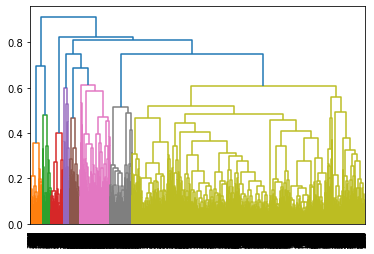

In [9]:
models=BreastCancerAnalysis()
models.fit_principal_components()
models.dendrogram()

In [10]:
models.cluster_proteins(8)

,,,cluster
RefSeq_accession_number,gene_symbol,gene_name,
NP_958782,PLEC,plectin isoform 1,6
NP_958785,NaN,plectin isoform 1g,6
NP_958786,PLEC,plectin isoform 1a,6
NP_000436,NaN,plectin isoform 1c,6
NP_958781,NaN,plectin isoform 1e,6
...,...,...,...
NP_001191293,NaN,protein FAM24B precursor,7
NP_775791,NaN,putative uncharacterized protein C9orf62,1
NP_004065,COX8A,"cytochrome c oxidase subunit 8A, mitochondrial",1


In [11]:
models.patient_cluster_activity()

cluster,0,1,2,3,4,5,6,7
TCGA-AO-A12D,0.917231,0.120564,-0.131219,-1.217355,1.694023,0.457643,0.660013,0.958409
TCGA-C8-A131,0.673408,0.104801,3.772445,-0.624512,0.805507,0.374236,0.601963,0.648450
TCGA-AO-A12B,-0.161929,-0.002945,-0.726941,-2.114828,-0.766855,-1.125559,-1.682631,-0.531601
TCGA-BH-A18Q,-2.379686,-0.258032,-1.217904,-0.507265,-0.576811,1.443751,-0.519773,-2.977502
TCGA-C8-A130,0.519268,0.145321,-0.787509,-0.602994,-0.273223,-0.437974,0.128785,0.656380
...,...,...,...,...,...,...,...,...
TCGA-BH-A0C7,0.286719,-0.127704,-0.006070,0.071831,-0.828869,-0.473030,0.190112,0.399791
TCGA-A2-A0SX,0.701843,-0.046272,2.132516,2.085149,-0.588166,1.413544,0.403965,0.845956
TCGA-263d3f-I,0.209740,0.234159,1.773149,3.657372,-0.349064,-0.176786,0.689142,-0.292076
TCGA-blcdb9-I,-0.074353,-0.052396,0.772905,1.145733,-0.285471,-0.535294,-0.407381,-0.646755


E:\python3.10\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
E:\python3.10\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To repro

<AxesSubplot:>

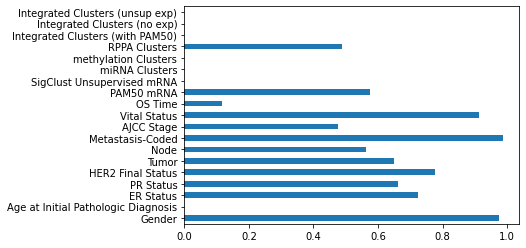

In [12]:
models.train_clinical_models()

<AxesSubplot:xlabel='cluster'>

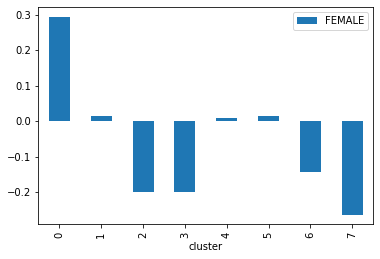

In [13]:
models.visualize('Gender')

<AxesSubplot:xlabel='cluster'>

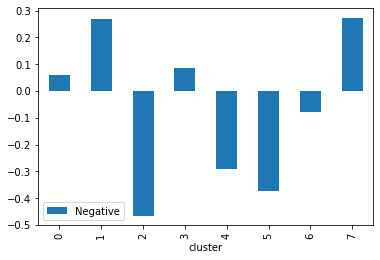

In [14]:
models.visualize('ER Status')

<AxesSubplot:xlabel='cluster'>

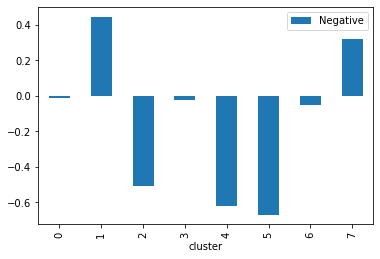

In [15]:
models.visualize('PR Status')

<AxesSubplot:xlabel='cluster'>

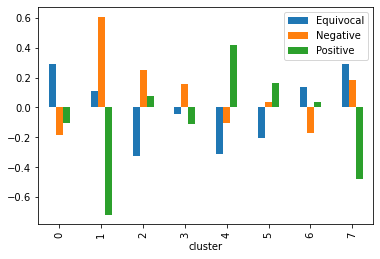

In [16]:
models.visualize('HER2 Final Status')

<AxesSubplot:xlabel='cluster'>

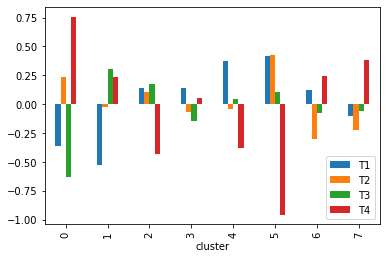

In [17]:
models.visualize('Tumor')

<AxesSubplot:xlabel='cluster'>

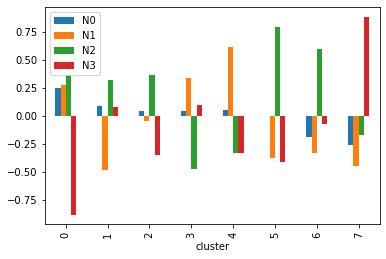

In [18]:
models.visualize('Node')

<AxesSubplot:xlabel='cluster'>

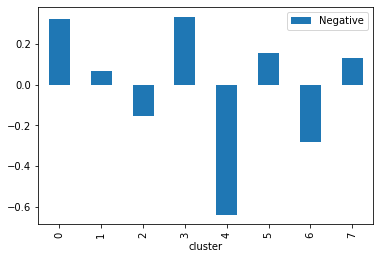

In [19]:
models.visualize('Metastasis-Coded')

<AxesSubplot:xlabel='cluster'>

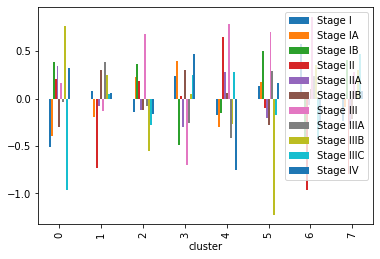

In [20]:
models.visualize('AJCC Stage')

<AxesSubplot:xlabel='cluster'>

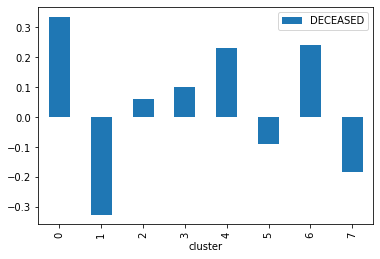

In [21]:
models.visualize('Vital Status')

<AxesSubplot:xlabel='cluster'>

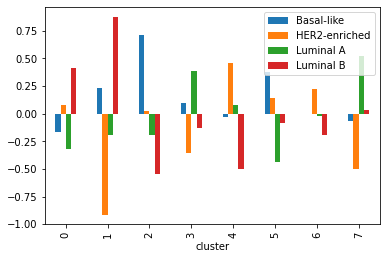

In [22]:
models.visualize('PAM50 mRNA')

<AxesSubplot:xlabel='cluster'>

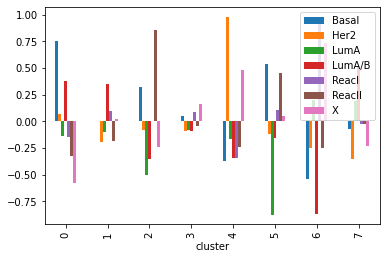

In [23]:
models.visualize('RPPA Clusters')